## Dog Breed Classification

In this project we will use traditional CNN, CNN with data augmentation and finally transfer Learning by VGG16 model with weights pre-trained on Imagenet to solve the dog breed classification problem

In [1]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-dd553738-aba8-45b0-4b1c-a9d5802c4ed3)


In [2]:
#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

Tue Apr 21 12:13:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [4]:
#no.of sockets i.e available slots for physical processors
!lscpu | grep 'Socket(s):'

Socket(s):           1


In [5]:
#no.of cores each processor is having 
!lscpu | grep 'Core(s) per socket:'

Core(s) per socket:  1


In [6]:
#no.of threads each core is having
!lscpu | grep 'Thread(s) per core'

Thread(s) per core:  2


In [7]:
!lscpu | grep "L3 cache" 

L3 cache:            56320K


In [8]:
#memory that we can use
!free -h --si | awk  '/Mem:/{print $2}'

13G


In [9]:
#hard disk space that we can use
!df -h / | awk '{print $4}'

Avail
34G


### Load Dataset Files

In [0]:
%tensorflow_version 2.x

In [11]:
%tensorflow_version

Currently selected TF version: 2.x
Available versions:
* 1.x
* 2.x


In [0]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Convolution2D,MaxPooling2D
from keras.utils import np_utils
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:

keras.__version__

'2.2.4'

Now, upload the given dataset file shared with you in your google drive and give its path for the below given `project_path` variable. For example, a path is given below according to the file path in our google drive. You need to change this to match the path of yours.

In [0]:
project_path = "/content/drive/My Drive/AIML_Project/Dog_breed/"

In [15]:
from __future__ import absolute_import, division, print_function
import pandas as pd
import numpy as np
import keras
from keras.datasets import cifar10, mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Reshape
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (15, 8)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [16]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Run the below code to extract all the images in the train.zip files given in the dataset. We are going to use these images as train and validation sets and their labels in further steps.

In [0]:
project_path = "/content/drive/My Drive/Colab Notebooks/CNN "

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'/train.zip', 'r') as z:
  z.extractall()

Repeat the same step for test.zip

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'/test.zip', 'r') as z:
  z.extractall()

Repeat the same step for sample_submission.csv.zip

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'/sample_submission.csv.zip', 'r') as z:
  z.extractall()

Repeat the same step for labels.csv.zip

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'/labels.csv.zip', 'r') as z:
  z.extractall()

After this process, we will have 4 files - Train folder, test folder and labels.csv and sample_submission.csv as part of your google drive

### Read labels.csv file using pandas

In [22]:
labels=pd.read_csv(project_path+'/labels.csv.zip')
labels.head(5)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


### Print the count of each category of Dogs given in the dataset



In [23]:
bc=labels['breed'].value_counts()
print(bc)

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
brabancon_griffon        67
komondor                 67
golden_retriever         67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64


### Get one-hot encodings of labels

In [0]:
# One Hot Endoing of labels
import numpy as np
targets = pd.Series(labels['breed'])
one_hot = pd.get_dummies(targets, sparse=True)
one_hot_labels = np.asarray(one_hot)

## Preparing training dataset
1. Write a code which reads each and every id from labels.csv file and loads the corresponding image (in RGB - 128, 128, 3) from the train folder. <br>
2. Create 2 variables <br> 
     a.  x_train - Should have all the images of the dogs from train folder <br>
     b.  y_train - Corresponding label of the dog <br>
<u>Note:</u> The id of the dog images and its corresponding labels are available in labels.csv file   
<u>Hint:</u> Watch the video shared on "Preparing the training dataset" if you face issue on creating the training dataset

In [25]:
img_rows=128
img_cols=128
num_channel=1

from tqdm import tqdm
import cv2

img_rows = 128
img_col = 128 
img_channel = 1

x_train = []
y_train = []

for id,breed in tqdm(labels.values):
  train_img = cv2.imread('./train/{}.jpg'.format(id),1)
  train_img_resize = cv2.resize(train_img, (img_rows,img_col))
  x_train.append(train_img_resize)
  y_train.append(breed)

100%|██████████| 10222/10222 [00:27<00:00, 375.27it/s]


In [26]:
x_train[0].shape

(128, 128, 3)

In [27]:
y_train[100]

'rhodesian_ridgeback'

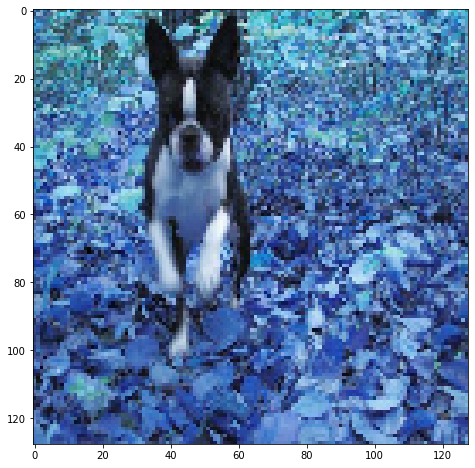

In [28]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])

In [29]:
y_train[0]

'boston_bull'

In [0]:
x_train1=np.array(x_train)

In [31]:
x_train2=np.array(x_train)
x_train2.shape

(10222, 128, 128, 3)

Normalize the training data and convert into 4 dimensions so that it can be used as an input to conv layers in the model

In [0]:
import pandas as pd
y_train = pd.get_dummies(y_train, sparse=True)

In [0]:
import numpy as np
x_train = np.array(x_train)
y_train = np.array(y_train)

In [34]:
print(y_train.shape)
print(x_train.shape)
print(y_train.dtype)

(10222, 120)
(10222, 128, 128, 3)
uint8


In [0]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_train /= 255

In [36]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

In [37]:
x_train1.shape

(10222, 128, 128, 3)

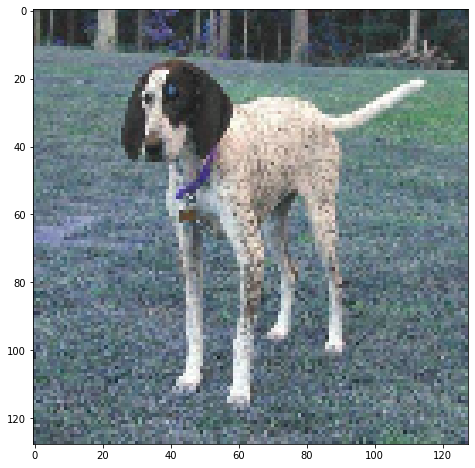

In [38]:
import matplotlib.pyplot as plt
plt.imshow(x_train[3])

### Split the training and validation data from `x_train_data` and `y_train_data` obtained from above step

In [39]:
from sklearn.model_selection import train_test_split
x_train2, x_val, y_train2, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=2)
print (len(x_train2))
print (len(x_val))

8177
2045


In [40]:
x_train2[0].shape

(128, 128, 3)

In [0]:
x_train2 = x_train2.reshape(x_train2.shape[0],128,128,3)

In [0]:
x_val = x_val.reshape(x_val.shape[0],128,128,3)

In [43]:
print (x_train2.shape)
print (x_val.shape)

(8177, 128, 128, 3)
(2045, 128, 128, 3)


In [44]:
print(y_val[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


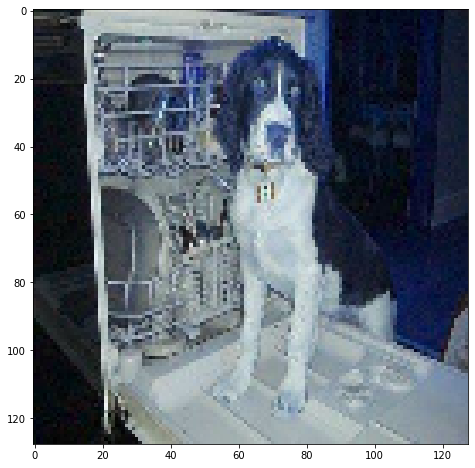

In [45]:
import matplotlib.pyplot as plt
plt.imshow(x_train2[0])

### Loading the test data
Read the id column from the samples_submission.csv and store it in test_img

In [0]:
import pandas as pd
sample_submission = pd.read_csv(project_path+'/sample_submission.csv.zip')

In [47]:
sample_submission.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333

In [0]:
test_img=sample_submission['id']

In [49]:
test_img.shape

(10357,)

In [50]:
test_img.head()

0    000621fb3cbb32d8935728e48679680e
1    00102ee9d8eb90812350685311fe5890
2    0012a730dfa437f5f3613fb75efcd4ce
3    001510bc8570bbeee98c8d80c8a95ec1
4    001a5f3114548acdefa3d4da05474c2e
Name: id, dtype: object

Run the below code to load the test image files in x_test_feature

In [51]:
img_rows = 128
img_col = 128 
img_channel = 1

x_test_feature = []

i = 0 # initialisation
for f in tqdm(test_img.values): # f for format ,jpg
    img = cv2.imread('./test/{}.jpg'.format(f), 1)
    img_resize = cv2.resize(img, (img_rows, img_col)) 
    x_test_feature.append(img_resize)

100%|██████████| 10357/10357 [00:27<00:00, 383.59it/s]


In [52]:
x_test_feature[0].shape

(128, 128, 3)

Normalize the test data and convert it into 4 dimensions

In [0]:
import numpy as np
x_test = np.array(x_test_feature)

In [0]:
x_test = x_test.astype('float32')
x_test /= 255

In [0]:
x_test = x_test.reshape(x_test.shape[0],128,128,3)

In [56]:
x_test.shape

(10357, 128, 128, 3)

In [57]:
print (x_test.shape)

(10357, 128, 128, 3)


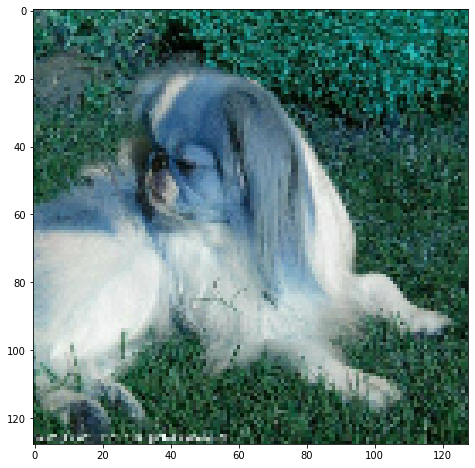

In [58]:
import matplotlib.pyplot as plt
plt.imshow(x_test[0])

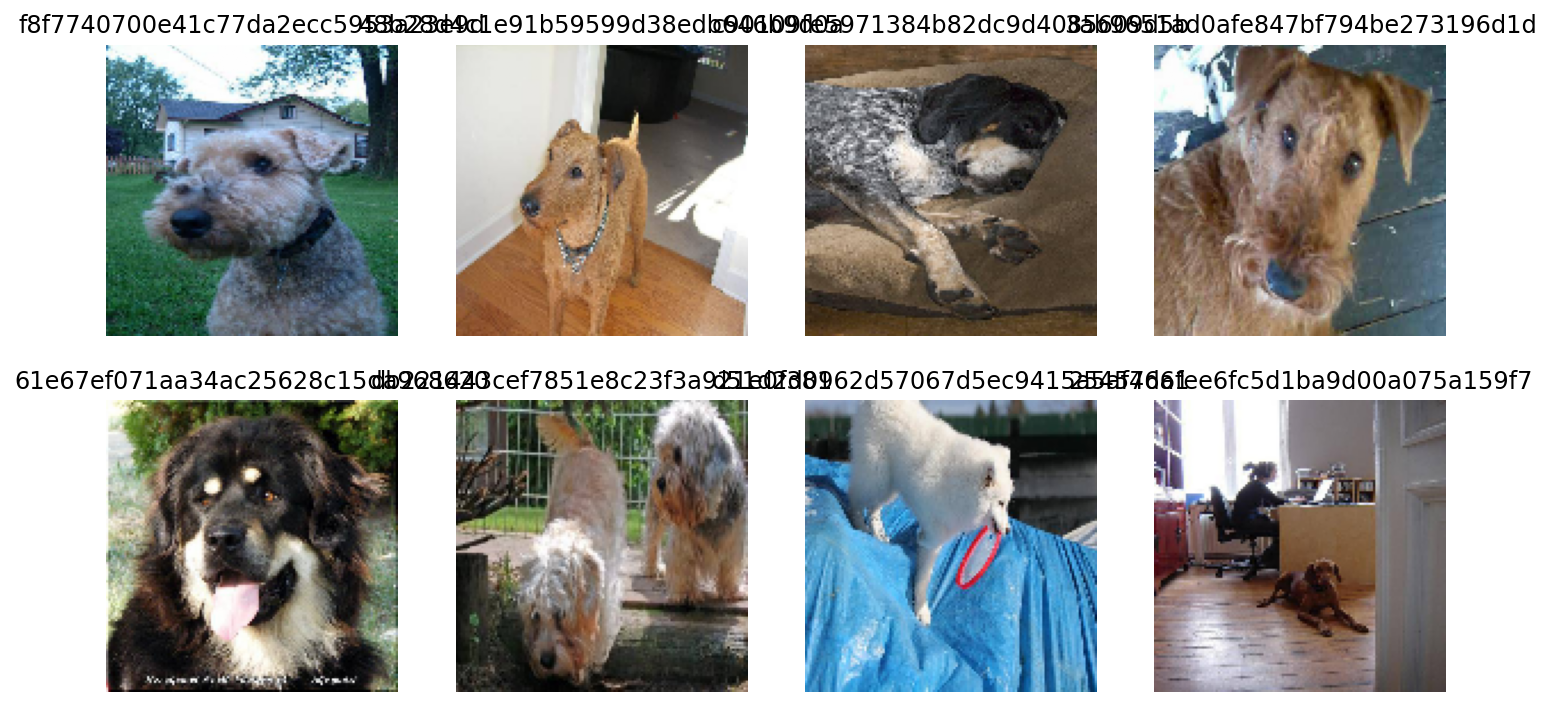

In [59]:
import random
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12, 6))
for i in range(8):
    random_index = random.randint(0, 10221)
    plt.subplot(2, 4, i+1)
    plt.imshow(x_test[random_index][:,:,::-1])
    plt.title(test_img[random_index])
    plt.axis('off')

### Build a basic conv neural network with 2 conv layers (kernel sizes - 5 and 3) add layers as mentioned below for classification.

1. Add a Dense layer with 256 neurons with `relu` activation

2. Add a Dense layer with 120 neurons as final layer (as there are 120 classes in the given dataset) with `softmax` activation for classifiaction. 

In [0]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
   
# 1st Conv Layer

model1 = tf.keras.Sequential()
model1.add(Convolution2D(32,5, 5, input_shape=(128, 128, 3)))
model1.add(BatchNormalization(axis=3, scale=False))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model1.add(Dropout(0.2))

# 2nd Conv Layer

model1.add(Convolution2D(32,3, 3, input_shape=(128, 128, 3)))
model1.add(BatchNormalization(axis=3, scale=False))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model1.add(Dropout(0.2))

# Fully Connected Layer
model1.add(Flatten())
model1.add(Dropout(0.2))
model1.add(Dense(256))
model1.add(Activation('relu'))

# Prediction Layer
model1.add(Dense(120))
model1.add(Activation('softmax'))

# Loss and Optimizer
model1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
# Store Training Results
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='auto')
callback_list = [early_stopping]

In [63]:
   # Train the model2
    model1.fit(x_train2, y_train2, batch_size=10, nb_epoch=10, validation_data=(x_val, y_val))

818/818 [==============================] - 4s 5ms/step - loss: 4.8263 - accuracy: 0.0136 - val_loss: 4.7775 - val_accuracy: 0.0103


### Use batch_size = 128 and epochs = 10 and execute the model

In [0]:
TRAIN = False
BATCH_SIZE = 128
EPOCHS = 50

In [65]:
history = model1.fit(x_train2, y_train2,epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1,validation_data=(x_val,y_val))

Epoch 1/50
64/64 [==============================] - 1s 20ms/step - loss: 4.7400 - accuracy: 0.0174 - val_loss: 4.7627 - val_accuracy: 0.0093
Epoch 2/50
64/64 [==============================] - 1s 18ms/step - loss: 4.7073 - accuracy: 0.0225 - val_loss: 4.7441 - val_accuracy: 0.0137
Epoch 3/50
64/64 [==============================] - 1s 19ms/step - loss: 4.6866 - accuracy: 0.0246 - val_loss: 4.7158 - val_accuracy: 0.0152
Epoch 4/50
64/64 [==============================] - 1s 18ms/step - loss: 4.6607 - accuracy: 0.0252 - val_loss: 4.6984 - val_accuracy: 0.0176
Epoch 5/50
64/64 [==============================] - 1s 19ms/step - loss: 4.6396 - accuracy: 0.0279 - val_loss: 4.6819 - val_accuracy: 0.0196
Epoch 6/50
64/64 [==============================] - 1s 19ms/step - loss: 4.6197 - accuracy: 0.0280 - val_loss: 4.6399 - val_accuracy: 0.0342
Epoch 7/50
64/64 [==============================] - 1s 19ms/step - loss: 4.6007 - accuracy: 0.0292 - val_loss: 4.6262 - val_accuracy: 0.0372
Epoch 8/50
64

#The model accuracy is very poor !!!!

### Use Data Augmentation in the above model to see if the accuracy improves


In [0]:
from keras.preprocessing.image import ImageDataGenerator
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=50,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True)  # randomly flip images

datagen.fit(x_train2)

### Using the above objects, create the image generators with variable names `train_generator` and `val_generator`

You need to use train_datagen.flow() and val_datagen.flow()

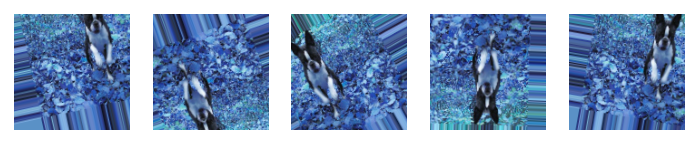

In [67]:
from matplotlib import pyplot as plt
train_generator = datagen.flow(x_train[0:1], batch_size=1)
for i in range(1, 6):
    plt.subplot(1,5,i)
    plt.axis("off")
    plt.imshow(train_generator.next().squeeze(), cmap='Blues')
    plt.plot()
plt.show()

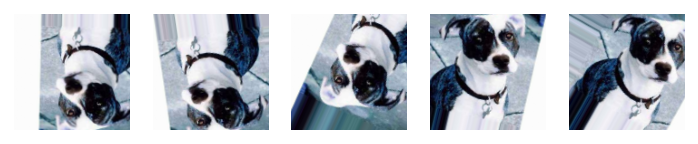

In [68]:
from matplotlib import pyplot as plt
val_generator = datagen.flow(x_val[0:1], batch_size=1)
for i in range(1, 6):
    plt.subplot(1,5,i)
    plt.axis("off")
    plt.imshow(val_generator.next().squeeze(), cmap='Blues')
    plt.plot()
plt.show()

### Fit the model using fit_generator() using `train_generator` and `val_generator` from the above step with 10 epochs

In [69]:
history =model1.fit(datagen.flow(x_train2, y_train2,batch_size=1), steps_per_epoch=x_train2.shape[0], epochs=10, validation_data=(x_val, y_val), callbacks=callback_list)

Epoch 1/10
8177/8177 [==============================] - 47s 6ms/step - loss: 4.8406 - accuracy: 0.0095 - val_loss: 4.8281 - val_accuracy: 0.0098
Epoch 2/10
8177/8177 [==============================] - 47s 6ms/step - loss: 4.8284 - accuracy: 0.0113 - val_loss: 4.8742 - val_accuracy: 0.0112
Epoch 3/10
8177/8177 [==============================] - 47s 6ms/step - loss: 4.8401 - accuracy: 0.0103 - val_loss: 4.8786 - val_accuracy: 0.0078
Epoch 4/10
8177/8177 [==============================] - 47s 6ms/step - loss: 4.8547 - accuracy: 0.0124 - val_loss: 4.8918 - val_accuracy: 0.0103
Epoch 5/10
8177/8177 [==============================] - 47s 6ms/step - loss: 4.8550 - accuracy: 0.0094 - val_loss: 4.9219 - val_accuracy: 0.0112
Epoch 6/10
8177/8177 [==============================] - 47s 6ms/step - loss: 4.8547 - accuracy: 0.0109 - val_loss: 4.9125 - val_accuracy: 0.0112
Epoch 7/10
8177/8177 [==============================] - 47s 6ms/step - loss: 4.8648 - accuracy: 0.0109 - val_loss: 4.9193 - val_ac

# Model accuracy is still poor!!!

### Lets use Transfer Learning

Download the vgg wieght file from here : https://github.com/MinerKasch/applied_deep_learning/blob/master/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

Use the below code to load VGG16 weights trained on ImageNet

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
# Instantiate the model with the pre-trained weights (no top)
base_model= VGG16(weights=('//content/drive/My Drive/Colab Notebooks/CNN /vgg16_weights_tf_dim_ordering_tf_kernels_notop (1).h5'),
                 include_top=False, pooling='avg')

In [71]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

Print the summary of the base_model

In [72]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### Add the following classification layers to the imported VGG Model <br>
1. Flatten Layer
2. Dense layer with 1024 neurons with activation as Relu
3. Dense layer with 256 neurons with activation as Relu
4. Dense layer with 120 neurons with activation as Softmax

In [0]:
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import *
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling3D


x = base_model.output
x = Flatten()(x)
x = Dropout(0.2)(x)
# let's add two fully-connected layer
x = Dense(1024, activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.2)(x)
# and a softmax layer for 120 classes
predictions = Dense(120, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)



In [74]:
# summarize
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### Make all the layers in the base_model (VGG16) to be non-trainable

In [75]:
for layer in base_model.layers:
  #if('conv' in layer.name): #prefix detection to freeze layers which does not have dense
    #Freezing a layer
    layer.trainable = False

#Module to print colourful statements
from termcolor import colored

#Check which layers have been frozen 
for layer in base_model.layers:
  print (colored(layer.name, 'blue'))
  print (colored(layer.trainable, 'red'))

input_1
False
block1_conv1
False
block1_conv2
False
block1_pool
False
block2_conv1
False
block2_conv2
False
block2_pool
False
block3_conv1
False
block3_conv2
False
block3_conv3
False
block3_pool
False
block4_conv1
False
block4_conv2
False
block4_conv3
False
block4_pool
False
block5_conv1
False
block5_conv2
False
block5_conv3
False
block5_pool
False
global_average_pooling2d
False


### Fit and compile the model with batch_size = 128 and epochs = 10 and execute the model

Try to get training and validation accuracy to be more than 90%

In [0]:
# Loss and Optimizer
from tensorflow.keras.optimizers import Adam
from keras.losses import categorical_crossentropy

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [77]:
history = model.fit(x_train2, y_train2,epochs=30, batch_size=128, verbose=1,validation_data=(x_val,y_val))

Epoch 1/30
64/64 [==============================] - 10s 156ms/step - loss: 4.7902 - accuracy: 0.0108 - val_loss: 4.7621 - val_accuracy: 0.0161
Epoch 2/30
64/64 [==============================] - 8s 128ms/step - loss: 4.7364 - accuracy: 0.0231 - val_loss: 4.7199 - val_accuracy: 0.0254
Epoch 3/30
64/64 [==============================] - 8s 127ms/step - loss: 4.6891 - accuracy: 0.0356 - val_loss: 4.6694 - val_accuracy: 0.0386
Epoch 4/30
64/64 [==============================] - 8s 128ms/step - loss: 4.6168 - accuracy: 0.0449 - val_loss: 4.5968 - val_accuracy: 0.0479
Epoch 5/30
64/64 [==============================] - 8s 127ms/step - loss: 4.5311 - accuracy: 0.0614 - val_loss: 4.5047 - val_accuracy: 0.0606
Epoch 6/30
64/64 [==============================] - 8s 127ms/step - loss: 4.4279 - accuracy: 0.0744 - val_loss: 4.4025 - val_accuracy: 0.0797
Epoch 7/30
64/64 [==============================] - 8s 129ms/step - loss: 4.3149 - accuracy: 0.0888 - val_loss: 4.3014 - val_accuracy: 0.0807
Epoch

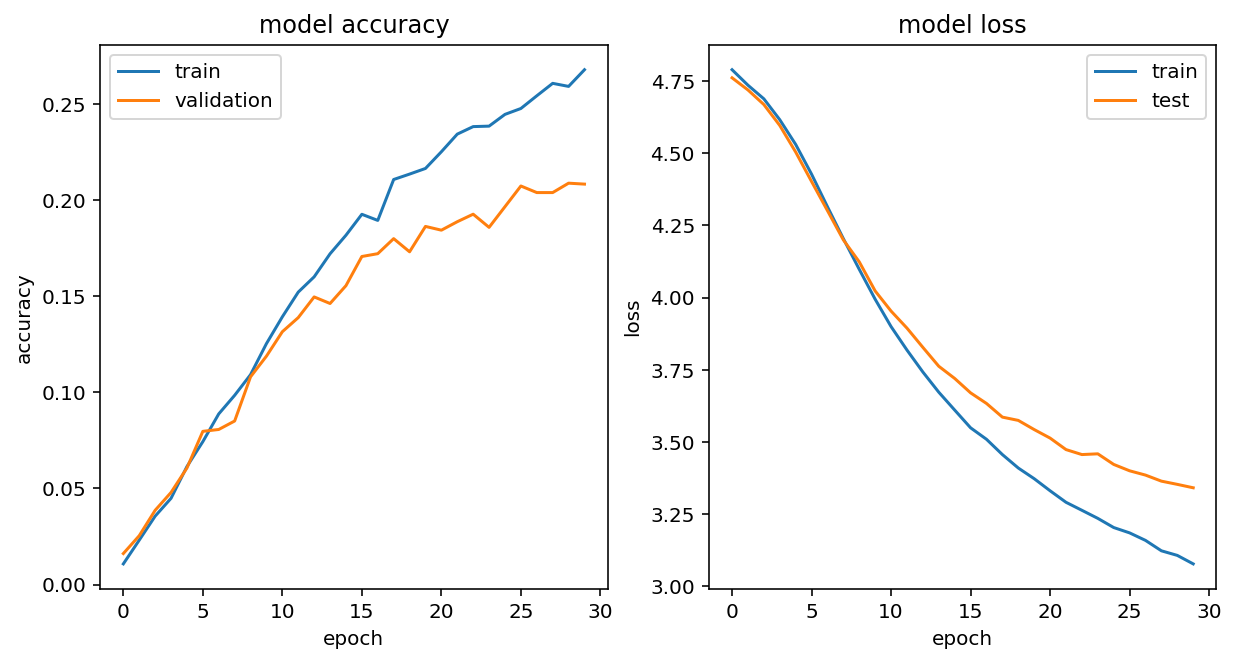

In [78]:
def plot_acc_loss(history):
    fig = plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
 
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
 
plot_acc_loss(history)

In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score
predictions = np.argmax(model.predict(x_val), axis=1)

In [0]:
predictions = np.argmax(model.predict(x_val), axis=1)


In [87]:
predictions

array([ 53, 115, 106, ...,  83, 100,  73])

In [88]:
y_val[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0.], dtype=float32)

In [0]:
y_val_label=np.argmax(y_val, axis=1)

In [90]:
y_val_label

array([104, 115,  46, ...,  81,  85,  73])

In [91]:
print("\nAccuracy on Test Data: ", accuracy_score(y_val_label, predictions))
print("\nNumber of correctly identified images: ",
      accuracy_score(y_val_label, predictions, normalize=False),"\n")
confusion_matrix(y_val_label, predictions)


Accuracy on Test Data:  0.20831295843520783

Number of correctly identified images:  426 



array([[5, 0, 0, ..., 0, 0, 0],
       [0, 9, 0, ..., 0, 0, 0],
       [0, 0, 5, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 2]])

trying to improve the accurecy 

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Creating a checkpointer 
checkpointer = ModelCheckpoint(filepath=('/content/drive/My Drive/Colab Notebooks/CNN /vgg16_weights_tf_dim_ordering_tf_kernels_notop (1).h5'), 
                               verbose=1,save_best_only=True)

In [93]:
# load the VGG16 network 
print("[INFO loading network...")
model_vgg = VGG16(weights="imagenet", include_top=False, input_shape=x_train.shape[1:])
model_vgg.summary()

[INFO loading network...
58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_____________________________________

In [94]:
from tensorflow.keras.layers import Dropout, Flatten, GlobalAveragePooling2D
model_transfer_full = Sequential()
model_transfer_full.add(model_vgg)
model_transfer_full.add(GlobalAveragePooling2D())
model_transfer_full.add(Dropout(0.2))
model_transfer_full.add(Dense(1024, activation='relu'))
model_transfer_full.add(Dense(256, activation='relu'))
model_transfer_full.add(Dense(120, activation='softmax'))
model_transfer_full.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_7 (Dense)              (None, 120)               30840     
Total params: 15,533,240
Trainable params: 15,533,240
Non-trainable params: 0
__________________________________________

In [95]:
opt = Adam(lr=0.00001)
model_transfer_full.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
history = model_transfer_full.fit(x_train2, y_train2, batch_size=32, epochs=20,
          validation_data=(x_val, y_val),callbacks=[checkpointer],verbose=1, shuffle=True)

Epoch 1/20
256/256 [==============================] - ETA: 0s - loss: 4.7941 - accuracy: 0.0110
Epoch 00001: val_loss improved from inf to 4.76806, saving model to /content/drive/My Drive/Colab Notebooks/CNN /vgg16_weights_tf_dim_ordering_tf_kernels_notop (1).h5
256/256 [==============================] - 24s 93ms/step - loss: 4.7941 - accuracy: 0.0110 - val_loss: 4.7681 - val_accuracy: 0.0127
Epoch 2/20
256/256 [==============================] - ETA: 0s - loss: 4.6372 - accuracy: 0.0286
Epoch 00002: val_loss improved from 4.76806 to 4.40288, saving model to /content/drive/My Drive/Colab Notebooks/CNN /vgg16_weights_tf_dim_ordering_tf_kernels_notop (1).h5
256/256 [==============================] - 24s 94ms/step - loss: 4.6372 - accuracy: 0.0286 - val_loss: 4.4029 - val_accuracy: 0.0831
Epoch 3/20
256/256 [==============================] - ETA: 0s - loss: 4.1825 - accuracy: 0.0934
Epoch 00003: val_loss improved from 4.40288 to 3.87829, saving model to /content/drive/My Drive/Colab Notebo

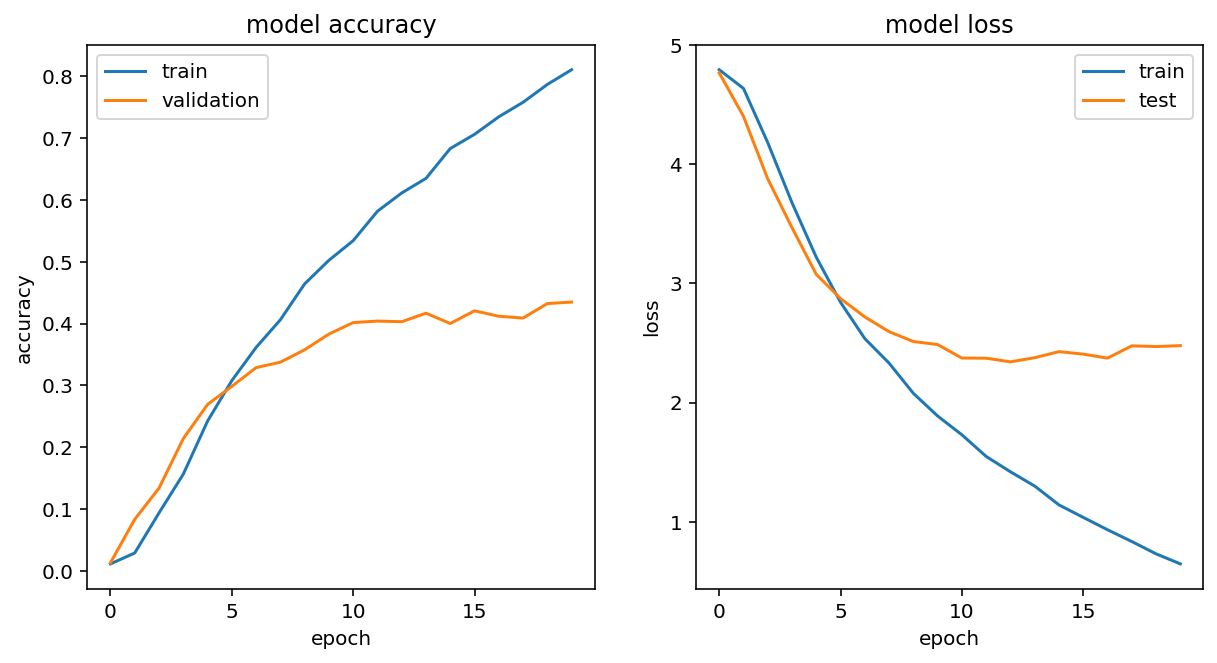

In [96]:
plot_acc_loss(history)

In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score
predictions = np.argmax(model_transfer_full.predict(x_val), axis=1)
y_val_label=np.argmax(y_val, axis=1)

In [98]:
print("\nAccuracy on Test Data: ", accuracy_score(y_val_label, predictions))
print("\nNumber of correctly identified images: ",
      accuracy_score(y_val_label, predictions, normalize=False),"\n")
confusion_matrix(y_val_label, predictions)


Accuracy on Test Data:  0.43471882640586795

Number of correctly identified images:  889 



array([[13,  0,  0, ...,  0,  0,  1],
       [ 0, 13,  0, ...,  0,  1,  0],
       [ 0,  0,  7, ...,  1,  0,  0],
       ...,
       [ 0,  0,  0, ...,  2,  0,  0],
       [ 0,  0,  0, ...,  0,  4,  0],
       [ 0,  0,  0, ...,  0,  0,  8]])

tried with partial vgg16 and full vgg 16 here while training data is not taking fullest of the dataset it is taking only 0.2 percent of the total data so accrecy is getting low in inital models but after doing transfer learning also model is not predicting the breed ..... so its is suspected that colab might be having some limitations 